In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['animation.embed_limit'] = 100

def animate_wigner(result):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    def update(n):
        ax.cla() # Clear axis. Without this, generating the animation takes a lot longer...
        plot_wigner(result.states[n],fig=fig,ax=ax)

    anim = animation.FuncAnimation(fig, update, frames=len(result.states))
    plt.close(fig)
    return anim

## Start: Damped linear HO

First, ringdown, lab frame. 

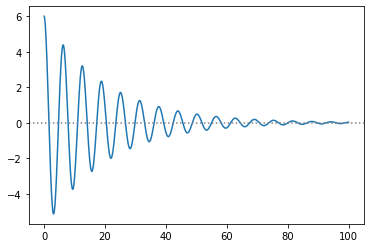

In [2]:
N = 30
a = destroy(N)
w = 1
H0 = w*a.dag() * a

gamma = 0.1 # Q = 10
c_ops = [np.sqrt(gamma) * a]

psi0 = coherent(N, 3)

t = np.linspace(0, 10/gamma, 1001)

options = Options()
#options.max_step = t[1]

result = mesolve(H0, psi0, t, c_ops,options=options)

plt.plot(t,np.real(expect(result.states, a+a.dag())))
plt.axhline(0,ls=':',c='grey')

Makes sense. Let's got to a "rotating frame", ie a transformation into a time-dependent basis that makes our calculation easier. The time dependent basis we will choose is that that represents the time evolution of the states under the action of H_0. 

In this "rotating" frame, we only need to include the effects of the interaction parts $V(t)$ of the Hamiltonian:

$$
H = H_0 + V(t)
$$

Specifically, 

$$
i\hbar \frac{d}{dt} 
\left| \psi \right \rangle = 
V(t) 
\left| \psi \right \rangle
$$

For us, we will have:

$$
H_0 = \hbar \omega a^\dagger a
$$

(We omit the 1/2 because it gives only an energy offset that does not influence the dynamics.)

Later, when we consider a driven Hamiltonian, it will be obvious that the driving term will represent our $V(t)$ time dependent perturbation operator. 

However, since we are solving an open quantum system using the Lindblad equation, we actually already have a perturbation of the Hamiltonian, since we have coupled ourselves to an external bath, represented by the collapse operator $\sqrt{\gamma} a$. 

And now a good question: do we need to transform the collapse operator? 

For the HO, this will mean that our collapse operator will acquire a time dependent phase. Since the collapse events are random and stochastic, I think that this phase operator is of no importance and can be neglected. I am not 100% sure if this is also applies for more complicated collapse operators? Good question. 


Concrete example: 

$$
H = \omega a^\dagger a
$$

Operator $a$ transforms into the rotating (interaction) frame as:

$$
a_I = e

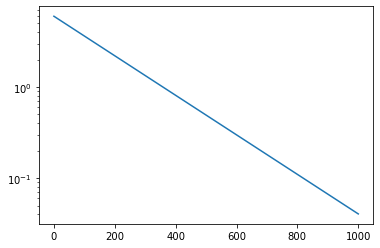

In [19]:
N = 30
a = destroy(N)
w = 0
H = w*a.dag() * a

gamma = 0.01 # Q = 10
c_ops = [np.sqrt(gamma) * a]

psi0 = coherent(N, 3)

t = np.linspace(0, 10/gamma, 1001)

options = Options()
#options.max_step = t[1]

result = mesolve(H, psi0, t, c_ops,options=options)

plt.plot(t,np.real(expect(result.states, a+a.dag())))
plt.axhline(0,ls=':',c='grey')
plt.yscale('log')

Good. Let's do driven HO, lab frame and rotating frame: 

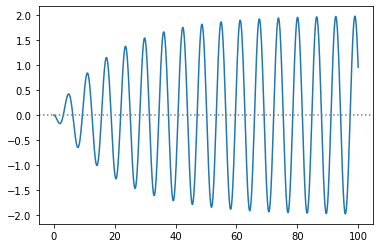

In [4]:
N = 50
a = destroy(N)
w = 1
H = w*a.dag() * a

eps = 0.1
H_d = eps * (a.dag() + a) 
w_d = w
def f_d(t, args):
    return np.cos(w_d*t)

gamma = 0.1 # Q = 10
c_ops = [np.sqrt(gamma) * a]

psi0 = coherent(N, 0)

t = np.linspace(0, 10/gamma, 1001)
result = mesolve([H,[H_d,f_d]], psi0, t, c_ops)

plt.plot(t,np.real(expect(result.states, a+a.dag())))
plt.axhline(0,ls=':',c='grey')

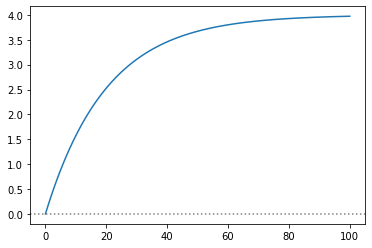

In [40]:
N = 30
a = destroy(N)
eps = 0.1
H = eps*(a+a.dag())

gamma = 0.1 # Q = 10
c_ops = [np.sqrt(gamma) * a]

psi0 = basis(N, 0)

t = np.linspace(0, 10/gamma, 101)
result = mesolve(H, psi0, t, c_ops)

op = 1j*(a-a.dag())
plt.plot(t,np.real(expect(result.states, op)))
plt.axhline(0,ls=':',c='grey')

In [29]:
animate_wigner(result)

OK, everything makes sense (aside, maybe, from the rotation...). In any case, let's take it to the next level: add the Kerr. 

## Kerr oscillator in the rotating frame

Ring up

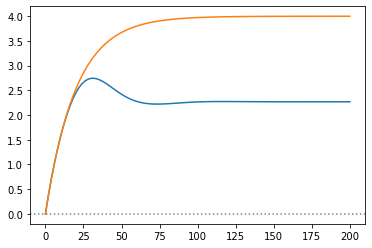

In [137]:
N = 30
a = destroy(N)
eps = 0.1
K = 0.01
H_d = eps*(a+a.dag()) 
H_K = K*a.dag()*a.dag()*a*a

gamma = 0.1 # Q = 10
c_ops = [np.sqrt(gamma) * a]

psi0 = basis(N, 0)

t = np.linspace(0, 20/gamma, 101)
ringup = mesolve(H_d + H_K, psi0, t, c_ops)
ringup_linear = mesolve(H_d, psi0, t, c_ops)

op = 1j*(a-a.dag())
plt.plot(t,np.real(expect(ringup.states, op)))
plt.plot(t,np.real(expect(ringup_linear.states, op)))
plt.axhline(0,ls=':',c='grey')

final_state = ringup.states[-1]
final_state_linear = ringup_linear.states[-1]

Now, try ring down

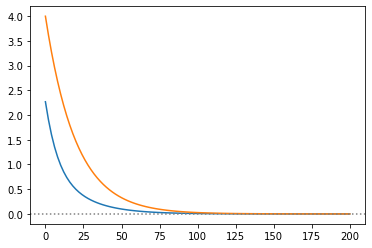

In [138]:
t = np.linspace(0, 20/gamma, 101)
ringdown = mesolve(H_K, final_state, t, c_ops)
ringdown_linear = mesolve(0*H_K, final_state_linear, t, c_ops)

op = 1j*(a-a.dag())
plt.plot(t,np.real(expect(ringdown.states, op)))
plt.plot(t,np.real(expect(ringdown_linear.states, op)))
plt.axhline(0,ls=':',c='grey')
#plt.yscale('log')

(-5.0, 100.0)

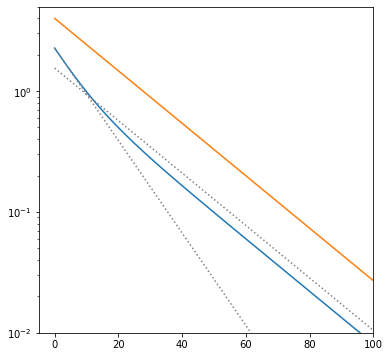

In [139]:
plt.figure(figsize=(6,6))
y1 = np.real(expect(ringdown.states, op))
y2 = np.real(expect(ringdown_linear.states, op))
plt.plot(t,y1)
plt.plot(t,y2)
plt.plot(t, 1.55*np.exp(-gamma*t/2),c='grey', ls=':')
gamma_nl = y2[0]/y1[0]*gamma
plt.plot(t, y1[0]*np.exp(-gamma_nl*t/2),c='grey', ls=':')
plt.axhline(0,ls=':',c='grey')
plt.yscale('log')
plt.ylim(1e-2,5)
plt.xlim(-5,100)

Text(0.5, 0, 'Time')

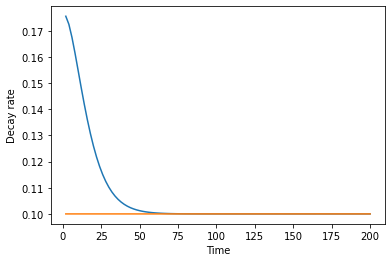

In [140]:
y3 = np.log(y1)
y4 = np.log(y2)
plt.plot(t[1:],-np.diff(y3))
plt.plot(t[1:],-np.diff(y4))
#plt.ylim(0,0.2)
plt.ylabel("Decay rate")
plt.xlabel("Time")
#plt.xlim(0,100)

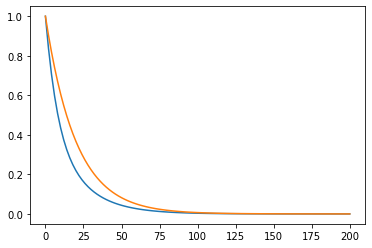

In [141]:
y1 = np.real(expect(ringdown.states, op))
y2 = np.real(expect(ringdown_linear.states, op))
y1 /= y1[0]
y2 /= y2[0]
plt.plot(t,y1)
plt.plot(t,y2)

Also fun: ring up and down

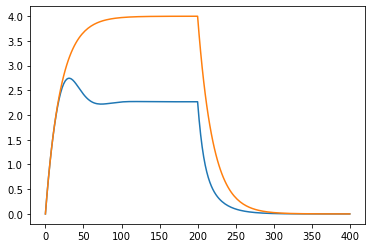

In [142]:
t2 = np.append(t,t+t[-1])
y1 = np.real(expect(ringup.states, op))
y1 = np.append(y1,np.real(expect(ringdown.states, op)))
y2 = np.real(expect(ringup_linear.states, op))
y2 = np.append(y2,np.real(expect(ringdown_linear.states, op)))
plt.plot(t2,y1)
plt.plot(t2,y2)

It could be that we have ended up a bit detuned...? That might explain the ringing. Maybe I need to decrease (well, actually, increase, since I've chosen K>0) the speed of the rotating frame?

# Classical nonlinear damping

I think we can approximate the classical nonlinear damping (to a good degree) by using a collapse operator a^dagger a a...?

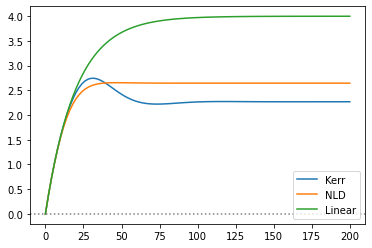

In [164]:
N = 30
a = destroy(N)
eps = 0.1
K = 0.01
H_d = eps*(a+a.dag()) 
H_K = K*a.dag()*a.dag()*a*a

gamma = 0.1 # Q = 10
beta = 0.2
c_ops = [np.sqrt(gamma) * a]
c_ops2 = [np.sqrt(gamma) * a, beta*np.sqrt(beta) * a.dag()*a*a]


psi0 = basis(N, 0)

t = np.linspace(0, 20/gamma, 101)
ringup = mesolve(H_d + H_K, psi0, t, c_ops)
ringup_nld = mesolve(H_d, psi0, t, c_ops2)
ringup_linear = mesolve(H_d, psi0, t, c_ops)

op = 1j*(a-a.dag())
plt.plot(t,np.real(expect(ringup.states, op)), label="Kerr")
plt.plot(t,np.real(expect(ringup_nld.states, op)), label="NLD")
plt.plot(t,np.real(expect(ringup_linear.states, op)), label="Linear")
plt.legend()
plt.axhline(0,ls=':',c='grey')

final_state = ringup.states[-1]
final_state_nld = ringup_nld.states[-1]
final_state_linear = ringup_linear.states[-1]

In [165]:
t = np.linspace(0, 20/gamma, 101)
ringdown = mesolve(H_K, final_state, t, c_ops)
ringdown_nld = mesolve(H_K, final_state_nld, t, c_ops2)
ringdown_linear = mesolve(0*H_K, final_state_linear, t, c_ops)

(0.1, 10)

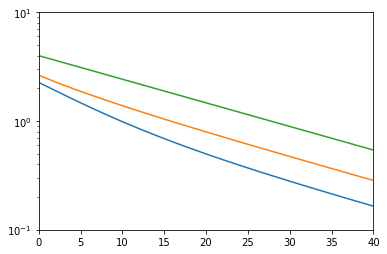

In [166]:
op = 1j*(a-a.dag())
plt.plot(t,np.real(expect(ringdown.states, op)))
plt.plot(t,np.real(expect(ringdown_nld.states, op)))
plt.plot(t,np.real(expect(ringdown_linear.states, op)))
plt.axhline(0,ls=':',c='grey')
plt.yscale('log')
plt.xlim(0,40)
plt.ylim(1e-1,10)

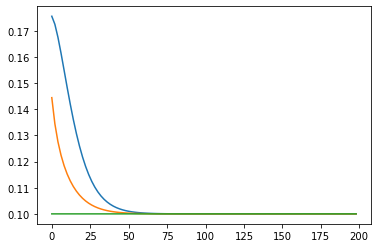

In [170]:
def plot(y):
    y = y/y[0]
    y2 = np.diff(np.log(y))
    plt.plot(t[:-1],-y2)

plot(np.real(expect(ringdown.states, op)))
plot(np.real(expect(ringdown_nld.states, op)))
plot(np.real(expect(ringdown_linear.states, op)))